In [18]:
import numpy as np
import matplotlib.pyplot as pl
import time

In [19]:
from varname import nameof, argname
def copier(arg):
    og_name = argname('arg')
    new_name = og_name + '_copy'
    globals()[new_name] = arg

In [20]:
c = 3e8
G = 6.67e-11
pi = np.pi
const = 96/5*pi**(8/3)*(G/c**3)**(5/3)

Specific arguments

In [93]:
f0 = 120
Mc = 1e-5* 2e30
f_max = 200
T_obs = 1e4
beta = const*f0**(8/3)*Mc**(5/3)

f_signal = 40*f_max
nt = round(f_signal*T_obs)
t = np.arange(nt)/f_signal

In [94]:
beta

9.473366100655505e-10

Generating signal and adding noise

In [95]:
phi = -6*pi/5*f0*(1-8./3.*beta*t)**(5/8)/beta
phi = np.mod(phi,2*pi)
signal = 1*np.exp(1j*phi)

nh = 0
noise = nh*np.random.normal(size = nt)
data = signal + noise

In [96]:
# np.savez('./Realisations/beta=%.2e_Realisation0' % beta, data)

In [97]:
# beta = 2.74e-07
# data = np.load('./Realisations/beta=%.2e_Realisation0.npz' % beta)['arr_0']

In [98]:
%reset_selective -f "^signal$"
# %reset_selective -f noise
%reset_selective -f phi

In [99]:
def strobo(beta, data, f_ratio):
    new_t = -3/5*(1-8/3*beta*t)**(5/8)/beta
    f_new = f_signal/f_ratio
    
    new_t *= f_new #changes the frequency to the new downsampled frequency (approximately, not exactly)
    floor_t = np.floor(new_t) #For some reason floor works better than round. Take it to the nearest time index which are integers
    idx = np.nonzero(np.diff(floor_t)) #The step that downsamples
    resampled = data[idx]
    t_out = (new_t[idx]-new_t[0])/f_new
    return (resampled, t_out)

In [100]:
f_ratio = 25
out, t_out = strobo(beta, data, f_ratio)
corrected = np.fft.fftshift(np.fft.fft(out))
freq_corrected = np.fft.fftshift(np.fft.fftfreq(len(t_out), d=t_out[1]-t_out[0]))
corrected = corrected[len(corrected)//2:]
resampled_power = np.abs(corrected/len(out))**2

freq_corrected = freq_corrected[len(freq_corrected)//2:]
nt_new = len(out)

(119.995, 120.005)

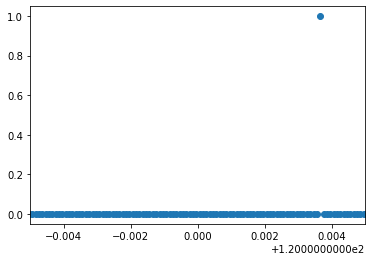

In [101]:
pl.plot(freq_corrected, np.abs(resampled_power), 'o')
pl.xlim(119.995, 120.005)

In [102]:
padded = np.full(3234000, 0, dtype = complex)
padded[:len(out)] = out
pad_corrected = np.fft.fftshift(np.fft.fft(padded))
pad_freq_corrected = np.fft.fftshift(np.fft.fftfreq(len(padded), d=t_out[1]-t_out[0]))
pad_resampled_power = np.abs(pad_corrected/len(padded))**2


(119.995, 120.005)

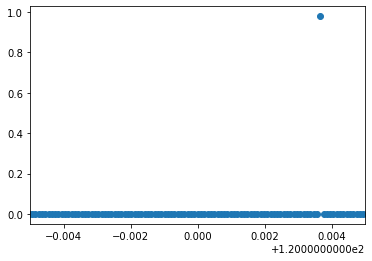

In [103]:
pl.plot(pad_freq_corrected, pad_resampled_power, 'o')
pl.xlim(119.995, 120.005)

In [104]:
3234000 - len(out)

33984

## With an offset

In [105]:
def inspecting(beta):
    new_t = -3/5*(1-8/3*beta*t)**(5/8)/beta
    out, t_out = strobo(beta, data, f_ratio)
    corrected = np.fft.fftshift(np.fft.fft(out))
    freq_corrected = np.fft.fftshift(np.fft.fftfreq(len(t_out), d=t_out[1]-t_out[0]))
#     corrected = corrected[len(corrected)//2:]
#     freq_corrected = freq_corrected[len(freq_corrected)//2:] # there is a bug here, isn't same length as resampled_power if even or odd
    resampled_power = np.abs(corrected/len(out))**2
    
    arg_max = np.argmax(resampled_power)
    peak_freq = freq_corrected[arg_max]
    peak_power = resampled_power[arg_max]
    return freq_corrected, resampled_power

In [106]:
temp_beta = (1+1e-3)*beta
new_t = -3/5*(1-8/3*temp_beta*t)**(5/8)/temp_beta
out, t_out = strobo(temp_beta, data, f_ratio)
corrected = np.fft.fftshift(np.fft.fft(out))
freq_corrected = np.fft.fftshift(np.fft.fftfreq(len(t_out), d=t_out[1]-t_out[0]))
#     corrected = corrected[len(corrected)//2:]
#     freq_corrected = freq_corrected[len(freq_corrected)//2:] # there is a bug here, isn't same length as resampled_power if even or odd
resampled_power = np.abs(corrected/len(out))**2

arg_max = np.argmax(resampled_power)
peak_freq = freq_corrected[arg_max]
peak_power = resampled_power[arg_max]

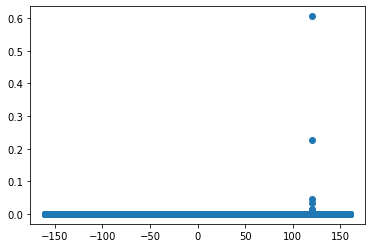

In [107]:
pl.plot(freq_corrected, resampled_power, 'o')
# pl.xlim(119.999, 120.001)

In [108]:
freq_corrected[1] - freq_corrected[0] 

0.00010000258311038124

In [109]:
f_signal / len(data)

0.0001

## Numerically estimating error

In [113]:
def power_calc(beta):
    new_t = -3/5*(1-8/3*beta*t)**(5/8)/beta
    out, t_out = strobo(beta, data, f_ratio)
    corrected = np.fft.fftshift(np.fft.fft(out))
    resampled_power = np.abs(corrected/len(out))**2
    freq_corrected = np.fft.fftshift(np.fft.fftfreq(len(t_out), d=t_out[1]-t_out[0]))
    
    arg_max = np.argmax(resampled_power)
    peak_freq = freq_corrected[arg_max]
    peak_power = resampled_power[arg_max]
    return peak_freq, peak_power

In [114]:
tic = time.time()
offset_arr = np.logspace(-8, -3, 100)
ref_freq, ref_power = power_calc(beta)

offset_results = np.array([power_calc(beta+i*beta) for i in offset_arr])
toc = time.time()
print((toc-tic)/60)

KeyboardInterrupt: 

In [ ]:
# pl.plot(offset_arr, offset_results[:,0]/ref_freq)
# pl.show()
pl.semilogx(offset_arr, offset_results[:,1]/ref_power, 'o')
pl.xlabel(r'$\Delta \beta / \beta$')
pl.ylabel('Power ratio')
pl.title(r'$\beta_{exact} = %.1E$' % beta)
pl.show()

## Padding the data

In [115]:
def pad_calc(beta):
    new_t = -3/5*(1-8/3*beta*t)**(5/8)/beta
    out, t_out = strobo(beta, data, f_ratio)
    padded = np.full(3234000, 0, dtype = complex)
    padded[:len(out)] = out
    pad_corrected = np.fft.fftshift(np.fft.fft(padded))
    pad_freq_corrected = np.fft.fftshift(np.fft.fftfreq(len(padded), d=t_out[1]-t_out[0]))
    pad_resampled_power = np.abs(pad_corrected/len(padded))**2
    
    arg_max = np.argmax(pad_resampled_power)
    peak_freq = pad_freq_corrected[arg_max]
    peak_power = pad_resampled_power[arg_max]
    return peak_freq, peak_power

In [119]:
tic = time.time()
offset_arr = np.logspace(-8, -1, 100)
ref_freq, ref_power = pad_calc(beta)

offset_results = np.array([pad_calc(beta+i*beta) for i in offset_arr])
toc = time.time()
print((toc-tic)/60)

5.69829136133194


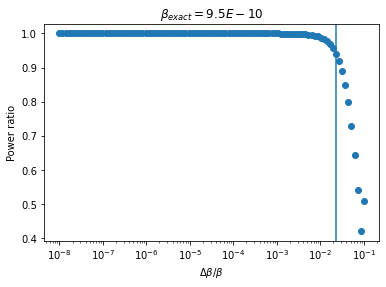

In [122]:
# pl.plot(offset_arr, offset_results[:,0]/ref_freq)
# pl.show()
pl.semilogx(offset_arr, offset_results[:,1]/ref_power, 'o')
pl.xlabel(r'$\Delta \beta / \beta$')
pl.ylabel('Power ratio')
pl.title(r'$\beta_{exact} = %.1E$' % beta)
pl.axvline(offset_arr[-10])
pl.show()

In [125]:
offset_results[-10,1]

0.9207023156213134

## Inspecting the jump

In [79]:
temp_beta = (1+offset_arr[-6])*beta
new_t = -3/5*(1-8/3*temp_beta*t)**(5/8)/temp_beta
out, t_out = strobo(temp_beta, data, f_ratio)
padded = np.full(3234000, 0, dtype = complex)
padded[:len(out)] = out
pad_corrected = np.fft.fftshift(np.fft.fft(padded))
pad_freq_corrected = np.fft.fftshift(np.fft.fftfreq(len(padded), d=t_out[1]-t_out[0]))
pad_resampled_power = np.abs(pad_corrected/len(padded))**2

arg_max = np.argmax(pad_resampled_power)
peak_freq = pad_freq_corrected[arg_max]
peak_power = pad_resampled_power[arg_max]

(119.995, 120.005)

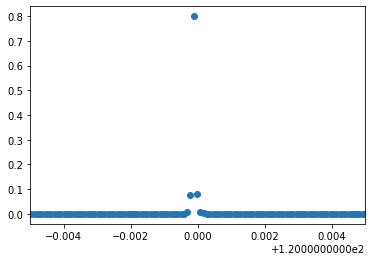

In [80]:
pl.plot(pad_freq_corrected, pad_resampled_power, 'o')
pl.xlim(119.995, 120.005)

In [84]:
temp_beta = (1+offset_arr[-12])*beta
new_t = -3/5*(1-8/3*temp_beta*t)**(5/8)/temp_beta
out, t_out = strobo(temp_beta, data, f_ratio)
padded = np.full(3234000, 0, dtype = complex)
padded[:len(out)] = out
pad_corrected = np.fft.fftshift(np.fft.fft(padded))
pad_freq_corrected = np.fft.fftshift(np.fft.fftfreq(len(padded), d=t_out[1]-t_out[0]))
pad_resampled_power = np.abs(pad_corrected/len(padded))**2

arg_max = np.argmax(pad_resampled_power)
peak_freq = pad_freq_corrected[arg_max]
peak_power = pad_resampled_power[arg_max]

(119.995, 120.005)

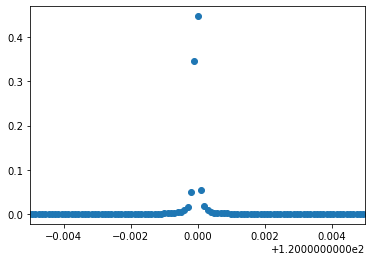

In [85]:
pl.plot(pad_freq_corrected, pad_resampled_power, 'o')
pl.xlim(119.995, 120.005)